In [15]:
# run initial imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from scipy.integrate import odeint
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.basemap import Basemap
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics 

from fbprophet import Prophet

from ipywidgets import widgets

from fbprophet.plot import plot_plotly
import plotly.offline as py

from datetime import datetime

In [16]:
NOW = datetime.now()

In [17]:
#setup initial data frames
input_dir = "./data/"
covid_19 = pd.read_csv(input_dir + 'combined.csv')

In [18]:
#correct date parsing on some of the JH data - and a just in case for the the other guys
covid_19['Last Update'] = pd.to_datetime(pd.to_datetime(covid_19['Last Update']).dt.date)
# and a date correction for plotly
covid_19['Date'] = pd.to_datetime(covid_19['Last Update']).apply(lambda date: date.strftime('%Y-%m-%d'))
covid_19 = covid_19.sort_values(['Last Update', 'Country/Region'])

In [19]:
#quick national overview
covid_19_countries = covid_19.groupby(['Last Update','Country/Region'])['Confirmed','Deaths','Active','Recovered'].sum().reset_index()
covid_19_overall = covid_19.groupby(['Last Update'])['Confirmed','Deaths','Active','Recovered'].sum().reset_index()

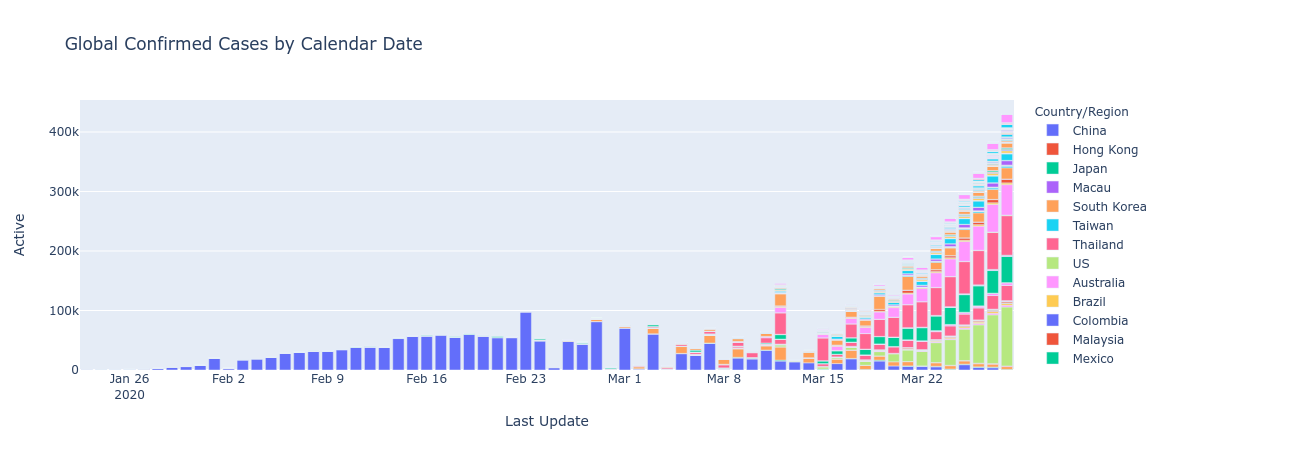

In [20]:
world_chart = px.bar(covid_19_countries, 
    x="Last Update", y="Active", color="Country/Region", title="Global Confirmed Cases by Calendar Date")
world_chart.show()

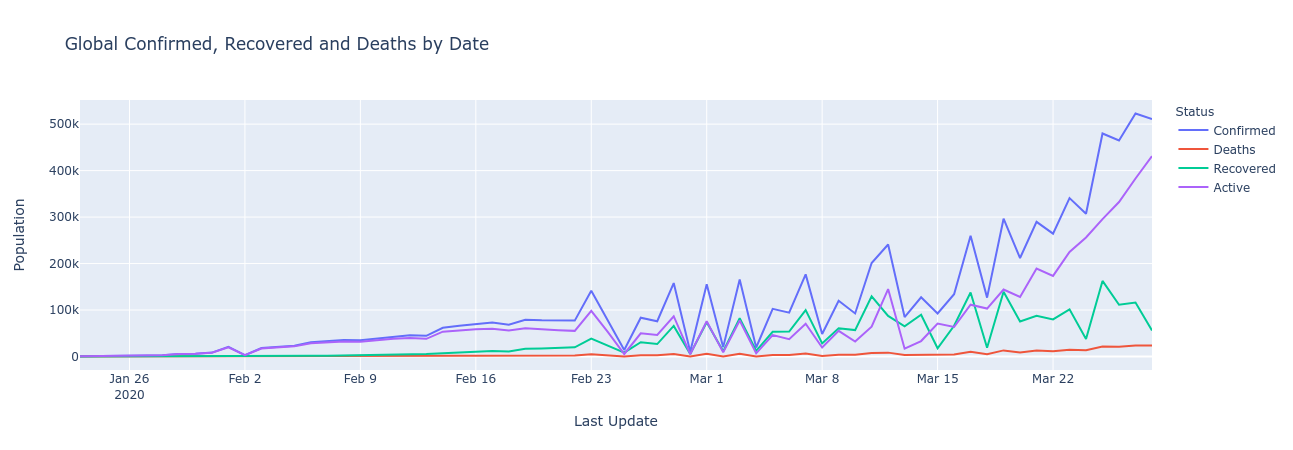

In [21]:
covid_19_world_totals_state = covid_19_overall[['Last Update', 'Confirmed', 'Deaths', 'Active', 'Recovered']].melt(id_vars=['Last Update'], 
            value_vars=['Confirmed', 'Deaths', 'Recovered', 'Active'], value_name="Population", var_name='Status')
world_chart = px.line(covid_19_world_totals_state, 
    x="Last Update", y="Population", color="Status", title="Global Confirmed, Recovered and Deaths by Date")
world_chart.show()
#world_chart.write_image('./www/global.png')

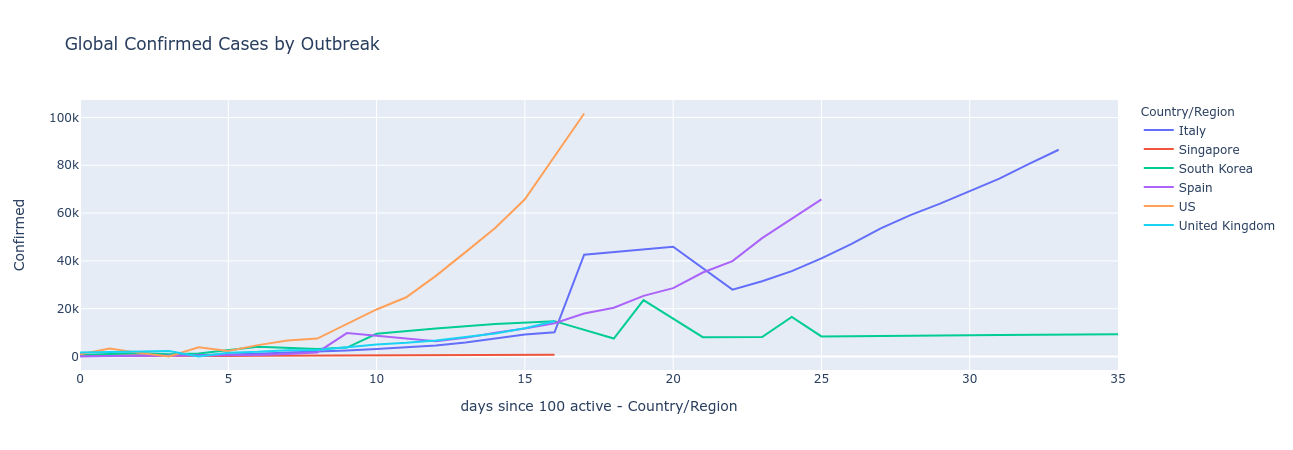

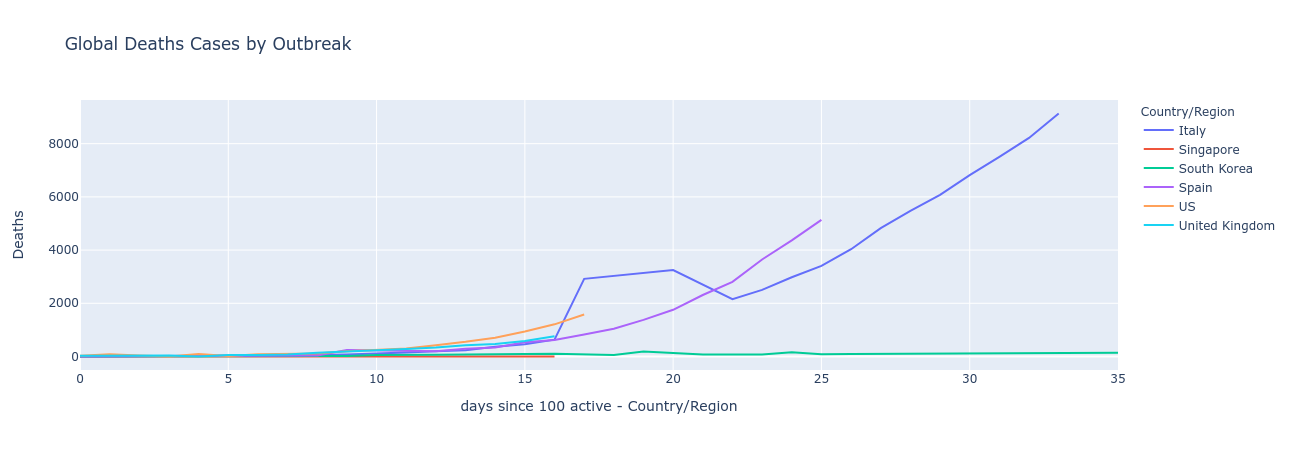

In [25]:
days_set = covid_19[covid_19['days since 100 active - Country/Region'] >= 0].copy()
countries = ['US', 'Italy', 'United Kingdom', 'Spain', 'South Korea', 'Singapore']
days_set = days_set[days_set['Country/Region'].isin(countries)]
days_set = days_set.groupby(['days since 100 active - Country/Region', 'Country/Region']).sum().reset_index()

world_chart = px.line(days_set, 
                      x="days since 100 active - Country/Region", y="Confirmed", color="Country/Region", 
                      title="Global Confirmed Cases by Outbreak", log_y=False)
world_chart.show()

world_chart = px.line(days_set, 
                      x="days since 100 active - Country/Region", y="Deaths", color="Country/Region", 
                      title="Global Deaths Cases by Outbreak", log_y=False)
world_chart.show()

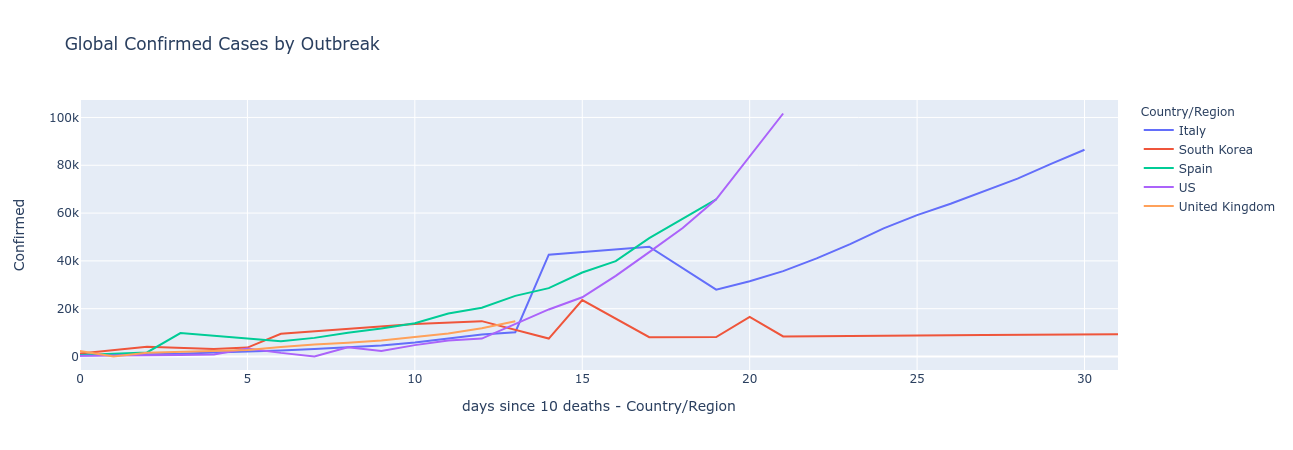

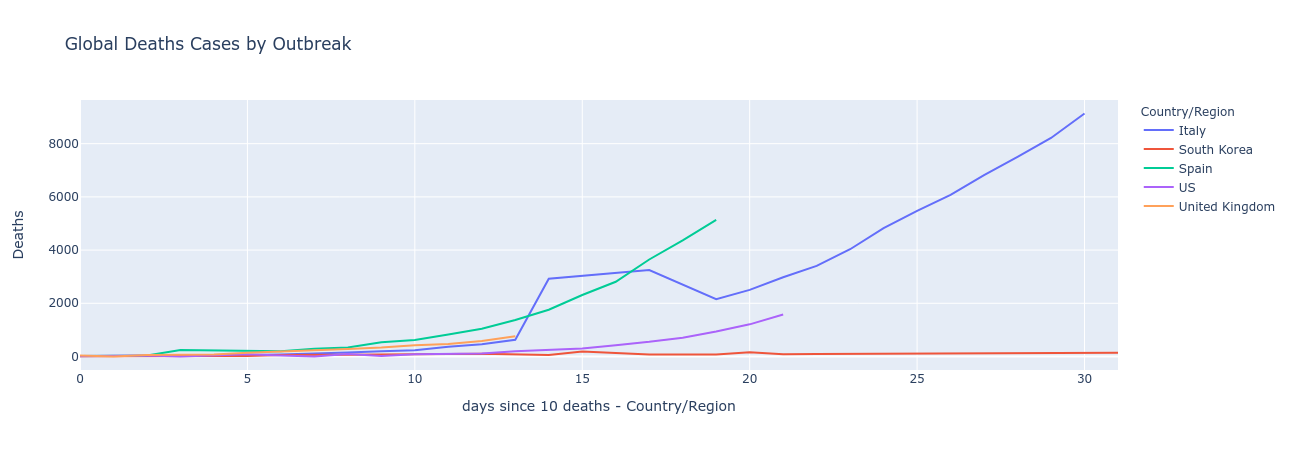

In [26]:
days_set = covid_19[covid_19['days since 10 deaths - Country/Region'] >= 0].copy()
countries = ['US', 'Italy', 'United Kingdom', 'Spain', 'South Korea', 'Singapore']
days_set = days_set[days_set['Country/Region'].isin(countries)]
days_set = days_set.groupby(['days since 10 deaths - Country/Region', 'Country/Region']).sum().reset_index()

world_chart = px.line(days_set, 
                      x="days since 10 deaths - Country/Region", y="Confirmed", color="Country/Region", 
                      title="Global Confirmed Cases by Outbreak", log_y=False)
world_chart.show()

world_chart = px.line(days_set, 
                      x="days since 10 deaths - Country/Region", y="Deaths", color="Country/Region", 
                      title="Global Deaths Cases by Outbreak", log_y=False)
world_chart.show()

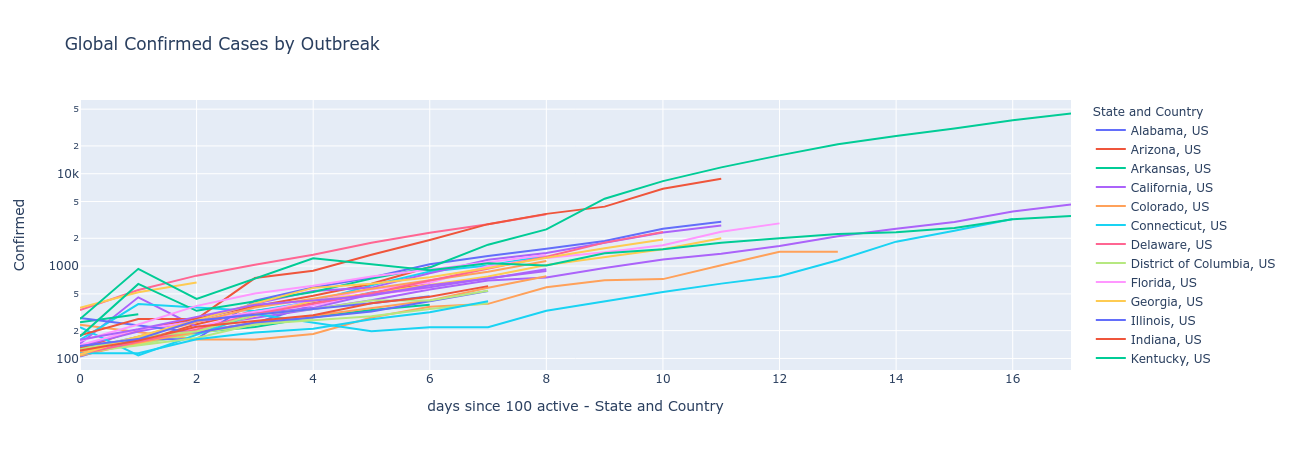

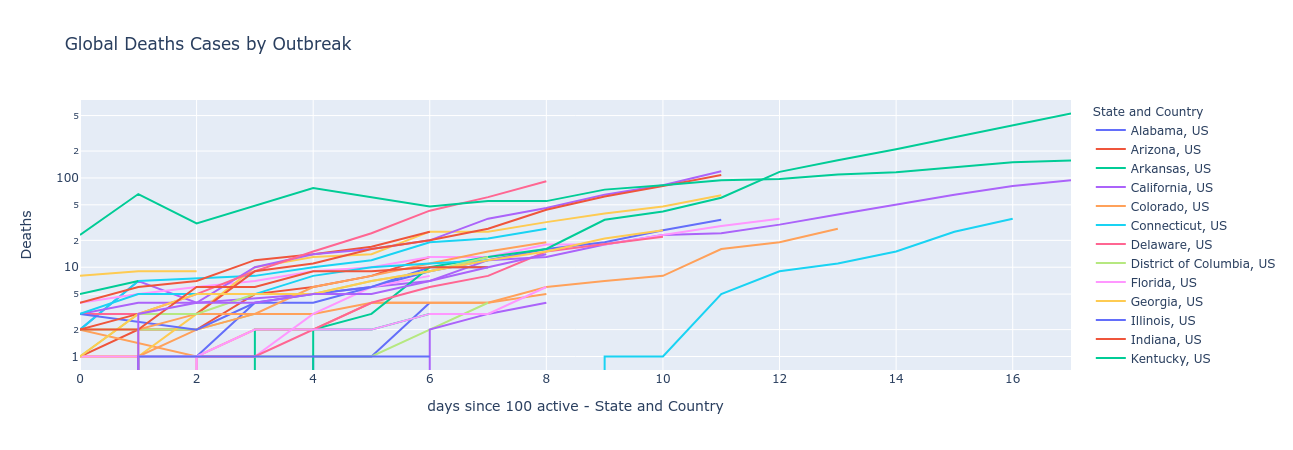

In [24]:
days_set = covid_19[covid_19['days since 100 active - State and Country'] >= 0].copy()
days_set = days_set[days_set['Country/Region'] == 'US']

days_set = days_set.groupby(['days since 100 active - State and Country', 'State and Country']).sum().reset_index()

us_chart = px.line(days_set, 
                      x="days since 100 active - State and Country", y="Confirmed", color='State and Country', 
                      title="US Cases by Outbreak", log_y=True)
us_chart.show()

us_chart = px.line(days_set, 
                      x="days since 100 active - State and Country", y="Deaths", color='State and Country', 
                      title="US Deaths Cases by Outbreak", log_y=True)
us_chart.show()

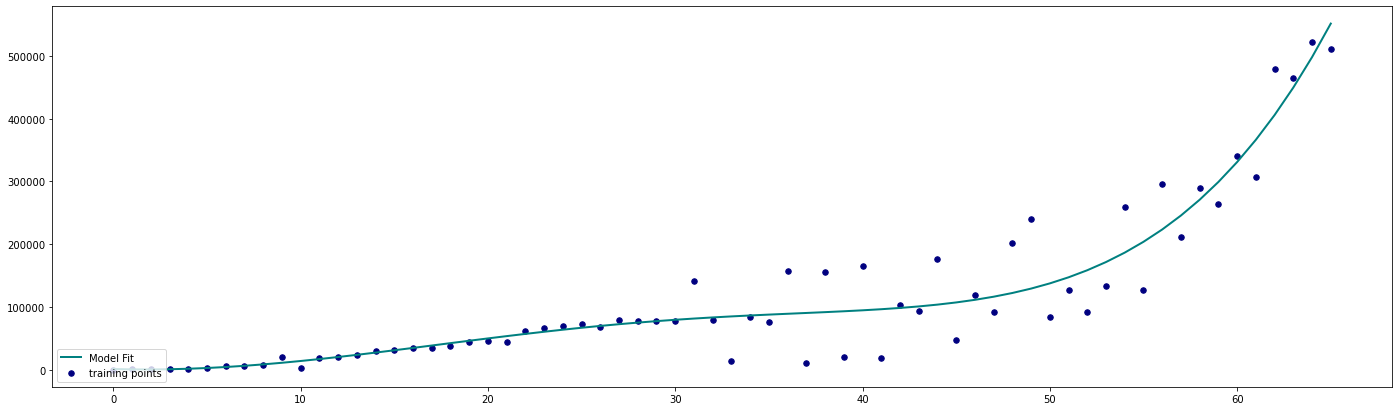

In [27]:
fDay=3

covid_19_world_totals=covid_19_overall.reset_index(drop=True)
covid_19_world_totals['Day'] = covid_19_world_totals.index
x=covid_19_world_totals.index
y=covid_19_world_totals['Confirmed']

x_plot = x

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2

plt.figure(figsize=(24,7))
#plt.plot(x, y, color='cornflowerblue', linewidth=lw,
#         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="Model Fit")

plt.legend(loc='lower left')

plt.show()

In [ ]:
fb_df = covid_19_overall[['Last Update', 'Confirmed']].copy()
fb_df = fb_df.sort_values('Last Update').reset_index(drop=True)
fb_df.columns = ['ds','y']
#print(fb_df)

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, growth='linear', n_changepoints=3)
m.fit(fb_df)

future = m.make_future_dataframe(periods=7)

forecast = m.predict(future)

In [ ]:
# uncomment to see the raw plot components
# fig2 = m.plot_components(forecast)

In [ ]:
py.init_notebook_mode()

fig = plot_plotly(m, forecast, xlabel='Date', ylabel='Confirmed Cases', uncertainty=True, figsize=(1200,600))  # This returns a plotly Figure
fig.update_layout(title='Confirmed Global COVID-19 Cases and Forecast')
py.iplot(fig)
#fig.write_html('./www/global_forecast.html')

In [ ]:
### Clustering needs a re-assesment once active cases are re-calculated post JH data update changes
# cluster_df = covid_19_infected_observations[['Day', 'Active Cases', 'Death', 'Recovered']]

# cluster_df = MinMaxScaler().fit_transform(cluster_df)
# db = DBSCAN(eps=0.01, min_samples=5).fit(cluster_df)
# labels = db.labels_
# covid_19_infected_observations['ClusterDB'] = labels

# cluster_df = pd.DataFrame(cluster_df)
# cluster_df.columns = ['Day', 'Active Cases', 'Death', 'Recovered']
# covid_19_infected_observations['Active Score'] = cluster_df['Active Cases']
# covid_19_infected_observations['Death Score'] = cluster_df['Death']

# cluster_df_days = covid_19_infected_observations[['Day', 'Max Day', 'Active Cases', 'Death', 'Recovered']]

# cluster_df_days = MinMaxScaler().fit_transform(cluster_df_days)
# db = DBSCAN(eps=0.025, min_samples=3).fit(cluster_df_days)
# labels = db.labels_
# covid_19_infected_observations['ClusterDBDays'] = labels

In [ ]:
# covid_19_infected_observations[['ClusterDB', 'Country/Region']].hist()
# covid_19_infected_observations[['ClusterDBDays', 'Country/Region']].hist()

In [ ]:
# cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterDB', 'ClusterDBDays', 'Active Cases', 'Death', 'Max Day']].copy().groupby('Country/Region').mean().reset_index()

In [ ]:
# show 3d cluster
# cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterDB', y='ClusterDBDays', z='Active Cases', color='Country/Region')
# cluster_plot_3d.update_layout(
#     width=1200, height=700
# )
# cluster_plot_3d.show()

In [ ]:
# cluster_plot = px.scatter(covid_19_infected_observations, x = 'Day', y='ClusterDB', color='Country/Region',  log_y=False)
# cluster_plot.show()

In [ ]:
# cluster_plot = px.scatter(cluster_plot_df, x = 'ClusterDB', y='ClusterDBDays', color='Country/Region',  log_y=True)
# cluster_plot.show()

In [ ]:
# cluster_km = KMeans(n_clusters=3)
# cluster_km.fit(cluster_df)
# labels = cluster_km.labels_
# covid_19_infected_observations['ClusterK5'] = labels

In [ ]:
# cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterK5', 'ClusterDB', 'Active Cases', 'Death']].copy().groupby('Country/Region').max().reset_index()
# cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterK5', y='Active Cases', z='Death', color='Country/Region')
# #cluster_plot_3d.show()

In [ ]:
# # let's show why kmeans/kmediods isn't sufficient for clustering this stuff
# cluster_plot = px.scatter(cluster_plot_df, x='ClusterK5', y='ClusterDB', color='Country/Region')
# cluster_plot.show()